In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import os
import time
import math
import random
from glob import glob
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import AutoModel, AutoTokenizer
from captum.attr import LayerIntegratedGradients
from openai import OpenAI

from language_training_utils import *

# import language_training_utils
# importlib.reload(language_training_utils)
# from language_training_utils import *

# Language Clustering

Clustering experiments with text feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

'descricao' token-length statistics:
Min: 2; Max: 420; 
Mean: 56.91137187559626; std: 35.49477155731764; 
Mode: ModeResult(mode=33, count=380); 
Q1: 32.0; 
Q2: 49.0; 
Q3: 73.0;
How many sentences longer than 128 tokens? 856



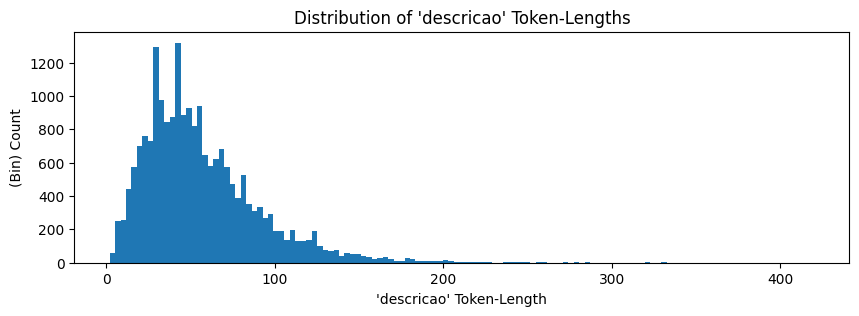

In [4]:
# Studying the distribution of sentence token-lengths on dataframe 'descricao' to make a 
# decision regarding the max sequence length to use for models (also with memory restrictions)
sentence_list = list(ind_df['descricao'].dropna())
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', \
                                          do_lower_case=False)
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in sentence_list]
token_lengths = np.array(token_lengths)

# Printing statistics and finding out that, given the small amount of sentences with more than
# 128 tokens, maybe we don't need to run an entire LLM pipeline to reduce sentence lengths. 
# Having said that, sequence length of 64 is pretty tight and would make us lose around 30%
# of our data with no LLM pipeline to reduce sentences
print("'descricao' token-length statistics:")
print(f"""Min: {np.min(token_lengths)}; Max: {np.max(token_lengths)}; 
Mean: {np.mean(token_lengths)}; std: {np.std(token_lengths)}; 
Mode: {stats.mode(token_lengths)}; 
Q1: {np.quantile(token_lengths, 0.25)}; 
Q2: {np.quantile(token_lengths, 0.50)}; 
Q3: {np.quantile(token_lengths, 0.75)};""")
print(f"How many sentences longer than 128 tokens? {len(np.where(token_lengths > 128)[0])}\n")

# Plotting distribution
plt.figure(figsize=(10, 3))
plt.hist(token_lengths, \
         bins=int(len(np.unique(token_lengths))/2))
plt.xlabel("'descricao' Token-Length")
plt.ylabel("(Bin) Count")
plt.title("Distribution of 'descricao' Token-Lengths")
plt.show()

Due to the very small amount of sentences with more than 128 tokens, and to the fact that, even those, are normally very close to 128 tokens, we first decided to postpone the bulding of an LLM pipeline to summarize longer sentences. Having said that, because of the bad quality of embeddings we got, we later decided to try reducing the sentences to more key aspects of it.

In [5]:
# Concatenating the descriptions an then mapping them to file splits for later API request
chunk_size=100
for i in range(0, len(sentence_list), chunk_size):
    chunk = sentence_list[i:i+chunk_size]
    file_num = i//chunk_size + 1
    file_name = f"senteces_{file_num}.txt"
    file_path = os.path.join('../data/raw_descriptions', file_name)

    # Write the chunk to file, one sentence per line
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(chunk))

In [6]:
# Function to load files
def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

# Initializing API client
groq_key = load_file('../data/groq').strip()
os.environ['OPENAI_API_KEY'] = groq_key
client = OpenAI(
    base_url='https://api.groq.com/openai/v1',
    api_key=os.environ['OPENAI_API_KEY'],
)

# Going through sentences, making request for LLM model and rewriting them
for file in tqdm(os.listdir('../data/raw_descriptions')):
    descriptions = load_file(os.path.join('../data/raw_descriptions', file))
    response = client.chat.completions.create(
        model='meta-llama/llama-4-scout-17b-16e-instruct',
        messages=[
            {
                'role': 'system',
                'content': "Reduza cada uma das sentenças para até 62 tokens sem modificar seu significado e preservando seus principais termos. Sua resposta deve contar apenas as sentenças reduzidas, uma por linha, sem nenhuma introdução ou saudação.",
            },
            {
                'role': 'user',
                'content': f'{descriptions}',
            },
        ],
        temperature=0.3,
        max_tokens=8192,
    )
    new_sentences = response.choices[0].message.content.strip()

    with open(os.path.join('../data/summarized_descriptions', file), \
              'w', encoding='utf-8') as f:
        f.write(new_sentences)

    # Don't exceeed API's (free) limit
    time.sleep(15)

  0%|                                     | 0/54 [00:00<?, ?it/s]


BadRequestError: Error code: 400 - {'error': {'message': '`max_tokens` must be less than or equal to `8192`, the maximum value for `max_tokens` is less than the `context_window` for this model', 'type': 'invalid_request_error'}}

In [ ]:
# Helper function to sort by the numeric suffix
def extract_index(file):
    return int(file.split('_')[-1].split('.')[0])

# Getting all (summarized) sentences in proper order
files = glob('../data/summarized_descriptions/sentences_*.txt')
files = sorted(files, key=extract_index)

summarized_sentence_list = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
        summarized_sentence_list.extend(lines)

# Creating column with summarized sentences
ind_df['descricao_resumida'] = ''
ind_df.loc[ind_df['descricao'].isna(), 'descricao_resumida'] = pd.NA
ind_df.loc[ind_df['descricao'].notna(), 'descricao_resumida'] = summarized_sentence_list

# Reanalyzing token distribution in sentences
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in summarized_sentence_list]
token_lengths = np.array(token_lengths)

# Plotting distribution
plt.figure(figsize=(10, 3))
plt.hist(token_lengths, \
         bins=int(len(np.unique(token_lengths))/2))
plt.xlabel("Summarized 'descricao' Token-Length")
plt.ylabel("(Bin) Count")
plt.title("Distribution of Summarized 'descricao' Token-Lengths")
plt.show()

## BERTimbau

### Vanilla Model

In [10]:
# Getting device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Initializing model, turning it into eval mode and zeroing out the gradients
model = AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased')
model = model.to(device)
model.eval()
model.zero_grad()

# Getting sentences' dataset, dataloader and splits
text_ind_df = ind_df[~ind_df['descricao'].isna()]
max_length = 64
text_dataset = TextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)

data_size = len(text_dataset)
train_size = int(0.8*data_size)
val_size = int(0.1*data_size)
test_size = data_size - train_size - val_size
splits = [train_size, val_size, test_size]
split_batch_size = 16
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)

# Initializing baseline input_ids and attention_mask, and computing its embedding
baseline_input_ids = torch.full((1, max_length), tokenizer.pad_token_id).to(device)
baseline_input_ids[:, 0] = tokenizer.cls_token_id
baseline_input_ids[:, -1] = tokenizer.sep_token_id
baseline_attention_mask = torch.zeros_like(baseline_input_ids).to(device)
baseline_attention_mask[:, 0] = 1
baseline_attention_mask[:, -1] = 1
with torch.no_grad():
    baseline_outputs = model(input_ids=baseline_input_ids, \
                             attention_mask=baseline_attention_mask)
    baseline_embedding = baseline_outputs.last_hidden_state[:, 0]

# Initializing captum compatible model and layer integrated gradients. We use layer integrated
# gradients here because we can't compute gradients with respect to (discrete) indices
# directly, so we compute gradients with respect to the embeddings of the input tokens
vanilla_wrapped_model = CaptumWrappedModel(model, tokenizer.pad_token_id, \
                                          baseline_embedding, device, target_type='cos-sim')
vanilla_wrapped_model.eval()

lig = LayerIntegratedGradients(vanilla_wrapped_model, model.embeddings)

In [11]:
# Iterating through the dataloader to compute embeddings and token attributions
analyzed_sample = 0
vanilla_bertimbau_indices = []
vanilla_bertimbau_embeddings = []
vanilla_bertimbau_tokens = []
vanilla_bertimbau_attributions = []
for indices, input_ids, _ in tqdm(text_dataloader):
    # Saving indices
    vanilla_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing [CLS] token embeddings
    cls_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=False)
    vanilla_bertimbau_embeddings.append(cls_embeddings.cpu().detach())

    # Computing attributions
    tokens, attributions, delta = get_attributions(lig, tokenizer, input_ids, \
                                                   baseline_input_ids, \
                                                   attrib_aggreg_type='l2-norm', \
                                                   return_tokens=True, \
                                                   verbose=False, \
                                                   sample_num=min(analyzed_sample, \
                                                                  full_batch_size-1))
    vanilla_bertimbau_tokens.append(tokens)
    vanilla_bertimbau_attributions.append(attributions)
    
# Concatenating the batches
vanilla_bertimbau_indices = np.array(vanilla_bertimbau_indices).squeeze(-1)
vanilla_bertimbau_embeddings = np.array(torch.cat(vanilla_bertimbau_embeddings, dim=0))
vanilla_bertimbau_tokens = np.array(vanilla_bertimbau_tokens)
vanilla_bertimbau_attributions = np.array(torch.cat(vanilla_bertimbau_attributions, dim=0))

  0%|                               | 0/20964 [00:00<?, ?it/s]

Token importances:
faca                 -> 0.0465
de                   -> 0.0345
material             -> 0.0248
orgânico             -> 0.0470
confeccionado        -> 0.0377
com                  -> 0.0177
ponta                -> 0.0193
lanceolada           -> 0.0482
de                   -> 0.0136
taquara              -> 0.0276
e                    -> 0.0130
cabo                 -> 0.0149
de                   -> 0.0114
madeira              -> 0.0116
roliça               -> 0.0354
.                    -> 0.0149
apresenta            -> 0.0222
engate               -> 0.0278
reforçado            -> 0.0219
com                  -> 0.0101
cera                 -> 0.0114
preta                -> 0.0119
revestido            -> 0.0229
de                   -> 0.0119
fios                 -> 0.0124
de                   -> 0.0116
algodão              -> 0.0114
,                    -> 0.0125
arrematado           -> 0.0409
com                  -> 0.0140
penas                -> 0.0145
vermelhas           

In [8]:
# Getting data projections
vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, \
vanilla_bertimbau_umap = data_projections(vanilla_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_bertimbau_trimap = normalize(vanilla_bertimbau_trimap, norm_factor)
vanilla_bertimbau_tsne = normalize(vanilla_bertimbau_tsne, norm_factor)
vanilla_bertimbau_umap = normalize(vanilla_bertimbau_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


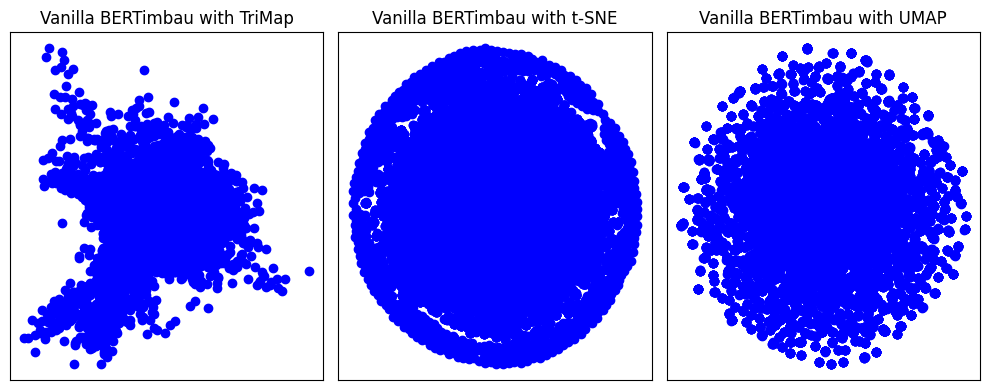

In [9]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=1, cols=3):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(10,4))
# plt.suptitle('Comparing Projections of BERTimbau Models')

# Plotting vanilla BERTimbau projections
projs = [vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, vanilla_bertimbau_umap]
proj_names = ['Vanilla BERTimbau with TriMap', 'Vanilla BERTimbau with t-SNE', \
              'Vanilla BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [10]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(vanilla_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   vanilla_bertimbau_attributions, vanilla_bertimbau_indices, \
                   save_file='vanilla_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(vanilla_bertimbau_umap, vanilla_bertimbau_tokens, \
                   vanilla_bertimbau_attributions, vanilla_bertimbau_indices, \
                   save_file='vanilla_bertimbau_umap.csv')

In [11]:
# Cleaning memory
clean_mem([vanilla_bertimbau_embeddings, vanilla_bertimbau_trimap, vanilla_bertimbau_tsne, \
vanilla_bertimbau_umap, vanilla_bertimbau_attributions, vanilla_bertimbau_indices])

### Unsupervised SimCSE (Contrastive Learning with no Labels)

  0%|                                     | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.0399 | Val Loss: 0.0084


  7%|█▋                        | 1/15 [06:02<1:24:28, 362.02s/it]

Epoch 2/15 | Train Loss: 0.0110 | Val Loss: 0.0077


 20%|█████▏                    | 3/15 [18:06<1:12:24, 362.04s/it]

Epoch 3/15 | Train Loss: 0.0096 | Val Loss: 0.0080
Epoch 4/15 | Train Loss: 0.0072 | Val Loss: 0.0075


 33%|████████▋                 | 5/15 [30:11<1:00:21, 362.13s/it]

Epoch 5/15 | Train Loss: 0.0082 | Val Loss: 0.0075


 40%|███████████▏                | 6/15 [36:12<54:17, 361.92s/it]

Epoch 6/15 | Train Loss: 0.0081 | Val Loss: 0.0075


 47%|█████████████               | 7/15 [42:13<48:13, 361.73s/it]

Epoch 7/15 | Train Loss: 0.0061 | Val Loss: 0.0075


 47%|█████████████               | 7/15 [48:15<55:09, 413.65s/it]

Epoch 8/15 | Train Loss: 0.0077 | Val Loss: 0.0075
Early stopping!


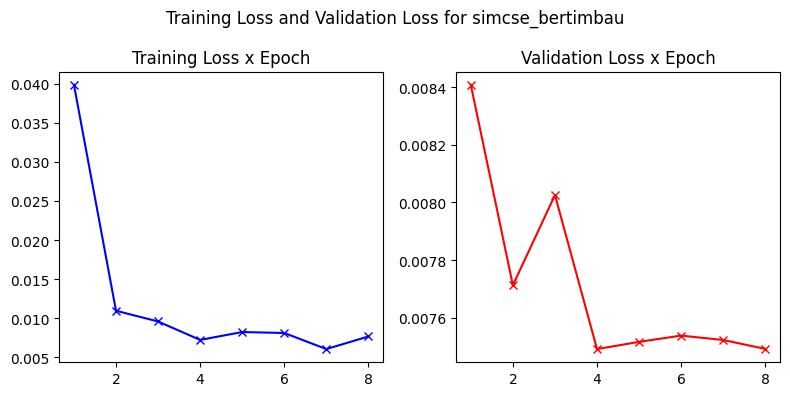

In [12]:
# Initializing SimCSE model and auxiliar variables
dropout_prob = 0.1
model = SimCSEModel(model, tokenizer.pad_token_id, device, dropout_prob)
lr = 2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
epochs = 15
temperature = 0.05
patience = max(4, math.ceil(epochs*0.1))
model_name = 'simcse_bertimbau'
train_dataloader, val_dataloader, test_dataloader = text_dataloader_splits

# Calling training process
simcse_indices, simcse_embeddings, \
train_losses, val_losses = contrastive_training_loop(model, optimizer, train_dataloader, \
                                                     val_dataloader, device, epochs, \
                                                     temperature, patience, model_name)

plot_training_curves(train_losses, val_losses, model_name)

In [13]:
# Recomputing baseline embedding for fine-tuned model
with torch.no_grad():
    baseline_embedding = model(input_ids=baseline_input_ids, train=False)

# Intanciating attribution computation class for fine-tuned model
simcse_wrapped_model = CaptumWrappedModel(model.model, tokenizer.pad_token_id, \
                                          baseline_embedding, device, target_type='cos-sim')
simcse_wrapped_model.eval()
lig = LayerIntegratedGradients(simcse_wrapped_model, model.model.embeddings)

# Iterating through the dataloader to compute token attributions for fine-tuned model
analyzed_sample = 0
simcse_bertimbau_indices = []
simcse_bertimbau_embeddings = []
simcse_bertimbau_attributions = []
for indices, input_ids, _ in tqdm(text_dataloader):
    # Saving indices
    simcse_bertimbau_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing [CLS] token embeddings
    cls_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=True)
    simcse_bertimbau_embeddings.append(cls_embeddings.cpu().detach())

    # Computing attributions
    attributions, delta = get_attributions(lig, tokenizer, input_ids, baseline_input_ids, \
                                           attrib_aggreg_type='l2-norm', \
                                           return_tokens=False, verbose=False, \
                                           sample_num=min(analyzed_sample, full_batch_size-1))
    simcse_bertimbau_attributions.append(attributions)

# Concatenating the batches
simcse_bertimbau_indices = np.array(simcse_bertimbau_indices).squeeze(-1)
simcse_bertimbau_embeddings = np.array(torch.cat(simcse_bertimbau_embeddings, dim=0))
simcse_bertimbau_attributions = np.array(torch.cat(simcse_bertimbau_attributions, dim=0))

100%|████████████████████| 20964/20964 [2:15:35<00:00,  2.58it/s]


In [15]:
# Getting data projections
simcse_bertimbau_trimap, simcse_bertimbau_tsne, \
simcse_bertimbau_umap = data_projections(simcse_bertimbau_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
simcse_bertimbau_trimap = normalize(simcse_bertimbau_trimap, norm_factor)
simcse_bertimbau_tsne = normalize(simcse_bertimbau_tsne, norm_factor)
simcse_bertimbau_umap = normalize(simcse_bertimbau_umap, norm_factor)

/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

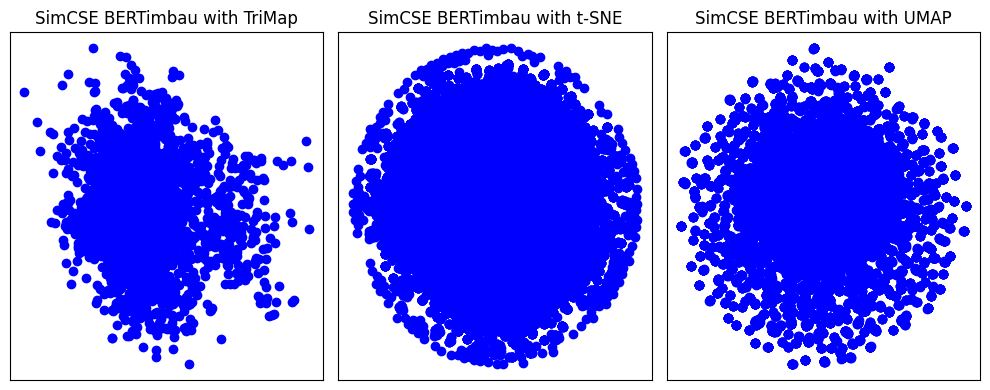

In [17]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting SimCSE BERTimbau projections
projs = [simcse_bertimbau_trimap, simcse_bertimbau_tsne, simcse_bertimbau_umap]
proj_names = ['SimCSE BERTimbau with TriMap', 'SimCSE BERTimbau with t-SNE', \
              'SimCSE BERTimbau with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [19]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(simcse_bertimbau_trimap, vanilla_bertimbau_tokens, \
                   simcse_bertimbau_attributions, simcse_bertimbau_indices, \
                   save_file='simcse_bertimbau_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(simcse_bertimbau_umap, vanilla_bertimbau_tokens, \
                   simcse_bertimbau_attributions, simcse_bertimbau_indices, \
                   save_file='simcse_bertimbau_umap.csv')

In [ ]:
# Cleaning memory
clean_mem([simcse_bertimbau_embeddings, simcse_bertimbau_trimap, simcse_bertimbau_tsne, \
simcse_bertimbau_umap, simcse_bertimbau_attributions, simcse_bertimbau_indices])

## Albertina

In [ ]:
# Getting new tokenizer
tokenizer = AutoTokenizer.from_pretrained('PORTULAN/albertina-1b5-portuguese-ptbr-encoder', \
                                          use_fast=True)

# Initializing model, turning it into eval mode and zeroing out the gradients
model = AutoModel.from_pretrained('PORTULAN/albertina-1b5-portuguese-ptbr-encoder')
model = model.to(device)
model.eval()
model.zero_grad()

# Getting sentences' dataset, dataloader and splits
max_length = 64
text_dataset = TextDataset(text_ind_df, tokenizer, max_length=max_length)
full_batch_size = 1
text_dataloader = get_dataloaders(text_dataset, full_batch_size)

data_size = len(text_dataset)
train_size = int(0.8*data_size)
val_size = int(0.1*data_size)
test_size = data_size - train_size - val_size
splits = [train_size, val_size, test_size]
split_batch_size = 16
text_dataset_splits, text_dataloader_splits = get_dataloaders(text_dataset, \
                                                              split_batch_size, splits)

# Initializing baseline input_ids and attention_mask, and computing its embedding
baseline_input_ids = torch.full((1, max_length), tokenizer.pad_token_id).to(device)
baseline_input_ids[:, 0] = tokenizer.cls_token_id
baseline_input_ids[:, -1] = tokenizer.sep_token_id
baseline_attention_mask = torch.zeros_like(baseline_input_ids).to(device)
baseline_attention_mask[:, 0] = 1
baseline_attention_mask[:, -1] = 1
with torch.no_grad():
    baseline_outputs = model(input_ids=baseline_input_ids, \
                             attention_mask=baseline_attention_mask)
    baseline_embedding = baseline_outputs.last_hidden_state[:, 0]

# Initializing captum compatible model and layer integrated gradients. We use layer integrated
# gradients here because we can't compute gradients with respect to (discrete) indices
# directly, so we compute gradients with respect to the embeddings of the input tokens
vanilla_wrapped_model = CaptumWrappedModel(model, tokenizer.pad_token_id, \
                                          baseline_embedding, device, target_type='cos-sim')
vanilla_wrapped_model.eval()

lig = LayerIntegratedGradients(vanilla_wrapped_model, model.embeddings)

In [ ]:
# Iterating through the dataloader to compute embeddings and token attributions
analyzed_sample = 0
vanilla_albertina_indices = []
vanilla_albertina_embeddings = []
vanilla_albertina_tokens = []
vanilla_albertina_attributions = []
for indices, input_ids, _ in tqdm(text_dataloader):
    # Saving indices
    vanilla_albertina_indices.append(indices)
    
    # Moving appropriate tensors to device
    input_ids = input_ids.to(device)

    # Computing [CLS] token embeddings
    cls_embeddings = get_embeddings(model, tokenizer, input_ids, device, fine_tuned=False)
    vanilla_albertina_embeddings.append(cls_embeddings.cpu().detach())

    # Computing attributions
    tokens, attributions, delta = get_attributions(lig, tokenizer, input_ids, \
                                                   baseline_input_ids, \
                                                   attrib_aggreg_type='l2-norm', \
                                                   return_tokens=True, \
                                                   verbose=False, \
                                                   sample_num=min(analyzed_sample, \
                                                                  full_batch_size-1))
    vanilla_albertina_tokens.append(tokens)
    vanilla_albertina_attributions.append(attributions)
    
# Concatenating the batches
vanilla_albertina_indices = np.array(vanilla_albertina_indices).squeeze(-1)
vanilla_albertina_embeddings = np.array(torch.cat(vanilla_albertina_embeddings, dim=0))
vanilla_albertina_tokens = np.array(vanilla_albertina_tokens)
vanilla_albertina_attributions = np.array(torch.cat(vanilla_albertina_attributions, dim=0))

In [ ]:
# Getting data projections
vanilla_albertina_trimap, vanilla_albertina_tsne, \
vanilla_albertina_umap = data_projections(vanilla_albertina_embeddings)

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_albertina_trimap = normalize(vanilla_albertina_trimap, norm_factor)
vanilla_albertina_tsne = normalize(vanilla_albertina_tsne, norm_factor)
vanilla_albertina_umap = normalize(vanilla_albertina_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(10,4))

# Plotting SimCSE BERTimbau projections
projs = [vanilla_albertina_trimap, vanilla_albertina_tsne, vanilla_albertina_umap]
proj_names = ['Vanilla Albertina with TriMap', 'Vanilla Albertina with t-SNE', \
              'Vanilla Albertina with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b', 1, )

plt.tight_layout()
plt.show()

In [ ]:
# Saving outputs for visualization tool (trimap)
_ = saving_outputs(vanilla_albertina_trimap, vanilla_albertina_tokens, \
                   vanilla_albertina_attributions, vanilla_albertina_indices, \
                   save_file='vanilla_albertina_trimap.csv')

# Saving outputs for visualization tool (umap)
_ = saving_outputs(vanilla_albertina_umap, vanilla_albertina_tokens, \
                   vanilla_albertina_attributions, vanilla_albertina_indices, \
                   save_file='vanilla_albertina_umap.csv')

In [ ]:
# Cleaning memory
clean_mem([vanilla_albertina_embeddings, vanilla_albertina_trimap, vanilla_albertina_tsne, \
vanilla_albertina_umap, vanilla_albertina_attributions, vanilla_albertina_indices])